<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# INSTALL DEPENDENCIES
# Uncomment and run only once.
!pip install matplotlib numpy pandas scikit-learn scipy tensorflow pyclustering

In [2]:
# IMPORTS AND GLOBAL CONSTANTS

# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime, os
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import typing
import numpy.typing as np_typing

##MAIN PROGRAM VARIABLES##
##(0): dataset: np array of strings
##(1): dataframe: original dataset in its primal form
##(2): ratings_num_df: new dataframe storing the number of rated items per unique user
##(3): ratings_span_df: new dataframe storing the timespan in days for each user
##(4): minimum_ratings - maximum_ratings => ratings_df=> (i) final_df

# Constants
DATASET_FILE_PATH = "./Dataset.npy"
#Define the figures path
FIGURES_PATH = "figures"
os.makedirs(FIGURES_PATH, exist_ok=True)
# #Define the data folder path
DATAFOLDER_PATH = "datafiles"
os.makedirs(DATAFOLDER_PATH, exist_ok=True)

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive/')
  DATASET_FILE_PATH = "/content/drive/My Drive/Colab Notebooks/Dataset.npy"


2023-03-11 12:00:09.273236: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-11 12:00:09.297385: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-11 12:00:09.297962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 12:00:10.016791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dataset: np.ndarray = np.load(DATASET_FILE_PATH)
# TODO delete this when we fix performance
dataset = dataset[:min(1000000, dataset.size)]

In [4]:
def create_dataframe_cached(dataset: np.ndarray) -> pd.DataFrame:
    #Define the splitter lambda function in order to tokenize the initial string data.
    splitter: typing.Callable[[str], list[str]] = lambda s: s.split(",")
    #Apply the splitter lambda function on the string np array
    dataset = np.array([splitter(x) for x in dataset])
    #Set the pickle file for storing the initial dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "dataframe.pkl")
    #Check the existence of the specified file.
    if os.path.exists(pickle_file):
        #Load the pickle file
        dataframe: pd.DataFrame = pd.read_pickle(pickle_file)
        return dataframe
    else:
        #Create the dataframe object.
        dataframe = pd.DataFrame(dataset, columns=['User','Movie','Rating','Date'])
        #Convert the string elements of the "Users" series into integers
        dataframe["User"] = dataframe["User"].apply(lambda s:np.int64(s.replace("ur","")))
        #Convert the string elements of the "Movies" series into integers
        dataframe["Movie"] = dataframe["Movie"].apply(lambda s:np.int64(s.replace("tt","")))
        #Convert the string elements of the "Ratings" series into integers
        dataframe["Rating"] = dataframe["Rating"].apply(lambda s:np.int64(s))
        #Convert the string element of "Dates" series into datetime Object
        dataframe["Date"] = pd.to_datetime(dataframe["Date"])
        dataframe.to_pickle(pickle_file)
        return dataframe


dataframe: pd.DataFrame = create_dataframe_cached(dataset)

In [5]:
#Get the unique users in the dataset.
users = dataframe["User"].unique()
#Get the number of unique users
users_num = len(users)
#Get the unique movie items in the dataset.
movies = dataframe["Movie"].unique()
#Get the number of unique movies
movies_num = len(movies)
#Get the total number of existing ratings.
ratings_num = dataframe.shape[0]
#Report the number of unique Users and Movies in the dataset
print("INITIAL DATASET: {0} number of unique users and {1} of unique movies".format(users_num, movies_num))
#Report the total number of existing ratings in the dataset
print("INITIAL DATASET: {} total number of existing ratings".format(ratings_num))

INITIAL DATASET: 355343 number of unique users and 118274 of unique movies
INITIAL DATASET: 1000000 total number of existing ratings


In [6]:
def create_ratings_num_df_cached(dataframe: pd.DataFrame) -> pd.DataFrame:
    #Define the pickle file that will store the time span per user dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_num_df.pkl")
    #Check the existence of the previously defined pickle file
    if os.path.exists(pickle_file):
        #Load the pickle file
        ratings_num_df: pd.DataFrame = pd.read_pickle(pickle_file)
        return ratings_num_df
    else:
        ratings_num_df = dataframe.groupby("User")["Rating"].count().sort_values(ascending=False).reset_index(name="ratings_num")
        #Save the previously created dataframe to pickle
        ratings_num_df.to_pickle(pickle_file)
        return ratings_num_df


ratings_num_df: pd.DataFrame = create_ratings_num_df_cached(dataframe)

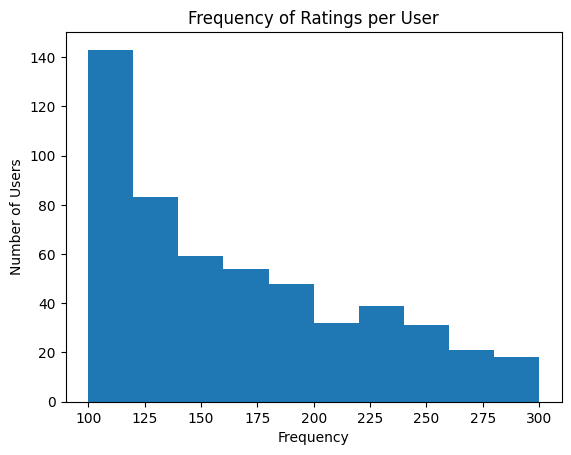

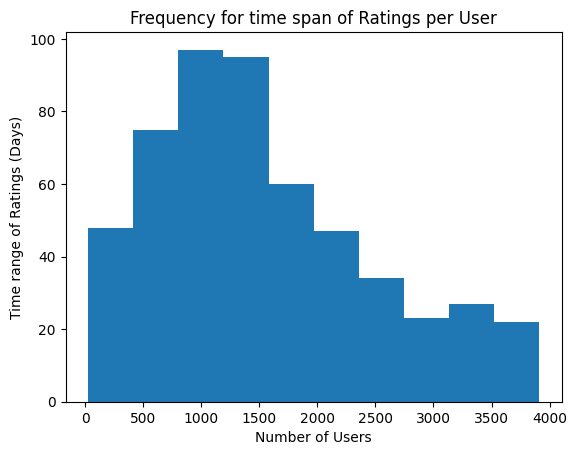

In [7]:
def create_ratings_span_df_cached(dataframe: pd.DataFrame) -> pd.DataFrame:
    #Set the pickle file that will store the time span per user dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_span_df.pkl")
    if os.path.exists(pickle_file):
        ratings_span_df: pd.DataFrame = pd.read_pickle(pickle_file)
        return ratings_span_df
    else:
        ratings_span_df = dataframe.groupby("User")["Date"].apply(lambda date: max(date)-min(date)).sort_values(ascending=False).reset_index(name="ratings_span")
        ratings_span_df.to_pickle(pickle_file)
        return ratings_span_df


def plot_histograms(reduced_ratings_df: pd.DataFrame):
    #Generate the frequency histogram for the number of ratings per user
    reduced_ratings_df["ratings_num"].plot(kind='hist', title='Frequency of Ratings per User', xticks=range(minimum_ratings, maximum_ratings+1, 25))
    plt.xlabel('Frequency')
    plt.ylabel('Number of Users')

    plt.show()
    #Generate the frequency histogram for the time span of ratings per user
    reduced_ratings_df["ratings_span"].plot(kind='hist', title='Frequency for time span of Ratings per User')
    plt.xlabel('Number of Users')
    plt.ylabel('Time range of Ratings (Days)')

    plt.show()   

ratings_span_df = create_ratings_span_df_cached(dataframe)

#Create a new ratings dataframe by joining the previously defined dataframe
ratings_df = ratings_num_df.join(ratings_span_df.set_index("User"),on="User")
ratings_df["ratings_span"]=ratings_df["ratings_span"].dt.days
#Set the threshold values for the minimum and maximum number of Ratings per user
minimum_ratings = 100
maximum_ratings = 300
#Discard all users that do not pertain to the previous range of ratings
reduced_ratings_df = ratings_df.loc[(ratings_df["ratings_num"] >= minimum_ratings) & (ratings_df["ratings_num"] <= maximum_ratings)]

plot_histograms(reduced_ratings_df)                                              

In [8]:
#Get the final dataframe by excluding all users whose ratings fall outside the prespecified range
final_df = dataframe.loc[dataframe["User"].isin(reduced_ratings_df["User"])].reset_index()
#Drop the links (indices) to the original table
final_df = final_df.drop("index", axis=1)
#Get the unique users and items in the final dataframe along with the final number of ratings
final_users = final_df["User"].unique()
final_movies = final_df["Movie"].unique()
final_users_num = len(final_users)
final_movies_num = len(final_movies)
final_ratings_num = len(final_df)

#Report the final number of unique users and movies in the dataset
print("REDUCED DATASET: {0} number of unique users and {1} number of unique movies".format(final_users_num, final_movies_num))
#Report the final number of existing ratings in the dataset
print("REDUCED DATASET: {} number of existing ratings in the dataset".format(final_ratings_num))

REDUCED DATASET: 528 number of unique users and 29635 number of unique movies
REDUCED DATASET: 87686 number of existing ratings in the dataset


In [9]:
#We need to reset the users and items IDs in order to be able to construct a network of users and Movies. 
#Users and Movies IDs should be consecutive in the [1..final_users_num] and [1...final_movies_num]
#Initially, we need to acquire the sorted versions of the user and movies
sorted_final_users = np.sort(final_users)
sorted_final_movies = np.sort(final_movies)
#Generate the dictionary of final users as a mapping of the following 
#sorted_final_users --> [0...final_users_num-1]
final_users_dict = dict(zip(sorted_final_users,list(range(0,final_users_num))))
#Generate the dictionary of final items as a mapping of the following
final_movies_dict = dict(zip(sorted_final_movies,list(range(0,final_movies_num))))
#Apply the previously defined dictionary-based maps on the users and movies columns of the final dataframe
final_df["User"] = final_df["User"].map(final_users_dict)
final_df["Movie"] = final_df["Movie"].map(final_movies_dict)
#Get a grouped version of the original dataframe based on the unique final users
users_group_df = final_df.groupby("User")
#Initialize the adjacency matrix which stores the connection status for pair of users in the recommendation network
W = np.zeros((final_users_num, final_users_num))
#Iinitialize the matrix storing the number of commonly rated items for a pair of users
CommonRatings = np.zeros((final_users_num, final_users_num))
#Initialize the matrix of common ratings
#Matrix W will be of size [final_users_num x final_users_num],
#Let U = {u1, u2,...,un} be the final set of users and I = {i1,i2,...,im}
#final set of movies. By considering the function Fi: U -> P(I) where
#P(I) is the powerset of I, Fi(u) returns the subset of items that has been rated by user u. 
#In this context, the edge weight between any given pair of users (u,v) will be computed as:
#
#          |Intersection(Fi(u)),Fi(v))|
#W(u,v) =  -----------------------------
#               |Union(Fi(u),Fi(v))|
#
#
#In order to speed up the construction of the adjacency matrix for the ratings network, 
#construct a dictionary object that will store a set of rated items for each unique user.
user_items_dict = {}
# for user in final_users:
    #print(user)
    # user_index = final_users_dict[user]
    # user_movies = set(users_group_df.get_group(user_index)["Movie"])
    # user_items_dict[user_index] = user_movies
                                                 
# Initialize the dictionary for storing the set of rated items for each user
user_items_dict = {}
# print(final_users_dict)
# print(sorted_final_users)
# print(final_users_dict)
# For each unique user, find the set of movies that they rated
for user in final_users:
    if user in final_users_dict:
        user_index = final_users_dict[user]
        user_movies = set(users_group_df.get_group(user_index)["Movie"])
        user_items_dict[user_index] = user_movies 

In [10]:
user_ids = list(user_items_dict.keys())
user_ids.sort()
#Generate the sorted version of the dictionary
user_items_dict = {user_index:user_items_dict[user_index] for user_index in user_ids}
#Set the pickle file that will store the graph adjacency matrix W.
pickle_file_weights = os.path.join(DATAFOLDER_PATH, "w")
pickle_file_common_ratings = os.path.join(DATAFOLDER_PATH, "common_ratings")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file_weights) & os.path.exists(pickle_file_common_ratings):
    #Load the pickle file
    W = np.load(pickle_file_weights)
    CommonRatings = np.load(pickle_file_common_ratings)
else:
    for source_user in user_items_dict.keys():
        for target_user in user_items_dict.keys():
            intersection_items = user_items_dict[source_user].intersection(user_items_dict[target_user])
            union_items = user_items_dict[source_user].union(user_items_dict[target_user])
            W[source_user, target_user] = len(intersection_items)/len(union_items)
            CommonRatings[source_user, target_user] = len(intersection_items)
    np.save(pickle_file_weights,W)
    np.save(pickle_file_common_ratings,CommonRatings)

In [11]:
W

array([[1.        , 0.00982801, 0.00645161, ..., 0.        , 0.        ,
        0.04229607],
       [0.00982801, 1.        , 0.0126183 , ..., 0.        , 0.        ,
        0.00854701],
       [0.00645161, 0.0126183 , 1.        , ..., 0.        , 0.        ,
        0.00393701],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.0513834 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04229607, 0.00854701, 0.00393701, ..., 0.0513834 , 0.        ,
        1.        ]])

In [12]:
CommonRatings

array([[201.,   4.,   2., ...,   0.,   0.,  14.],
       [  4., 210.,   4., ...,   0.,   0.,   3.],
       [  2.,   4., 111., ...,   0.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ..., 122.,   0.,  13.],
       [  0.,   0.,   0., ...,   0., 109.,   0.],
       [ 14.,   3.,   1., ...,  13.,   0., 144.]])

In [13]:
final_df

,User,Movie,Rating,Date
0,313,9972,10,2005-01-16
1,203,6243,2,2005-01-16
2,203,10103,2,2005-01-16
3,25,14694,7,2005-01-16
4,25,18942,3,2005-01-16
...,...,...,...,...
87681,115,14341,9,2001-06-29
87682,89,14342,4,2001-05-06
87683,116,14342,8,2001-09-05
87684,51,14343,9,1999-08-28


#Δημιουργούμε έναν πίνακα χρηστών - ταινιών 
(οι χρήστες βρίσκονται στις γραμμές και οι ταινίες στις στήλες του πίνακα)
όπου τα στοιχεία του πίνακα είναι από 1 - 10. Εάν ο χρήστης δεν έχει αξιολογήσει την ταινία,
η αξιολόγηση που θα ανατεθεί είναι 0.

In [14]:
# Create a pivot table of user-movie ratings
ratings_matrix = final_df.pivot_table(index='User', columns='Movie', values='Rating')
ratings_matrix = ratings_matrix.fillna(0)

In [15]:
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,29625,29626,29627,29628,29629,29630,29631,29632,29633,29634
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

Θέλουμε να δημιουργήσουμε τον πίνακα βαρών "λ" των χρηστών. Τον πίνακα αξιολογήσεων δηλαδή όπου η τιμή της αξιολόγησης είναι 1 εάν η ταινία έχει αξιολογηθεί από τον χρήστη ή 0 εάν δεν έχει αξιολογηθεί

In [17]:
# Threshold
threshold = 1

# Transform to binary
binary_matrix = np.where(ratings_matrix >= threshold, 1, 0)

In [18]:
binary_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
# Convert the matrix to a numpy array
matrix_array = ratings_matrix.to_numpy()

# Create a dictionary that maps each row of the matrix to its index
# matrix_dict = {tuple(row): i for i, row in enumerate(matrix_array)}

# ***Αλγόριθμοι Ομαδοποίησης Δεδομένων***

**Χρήση της Weighted Euclidean Distance**

In [20]:
from scipy.spatial.distance import pdist, cdist
import numpy as np

from scipy.sparse import csr_matrix

def pairwise_weighted_euclidean_distance(X, weights):
    # Find the indices of the rated movies for each pair of users
    rated_movies = (weights_sparse.T @ weights_sparse) > 0

    # Select only the rated movies for each pair of users
    X_rated = X_sparse[:, rated_movies]
    
    # Calculate the pairwise weighted Euclidean distance between 
    #users who have rated the same movie
    return cdist(X, metric='euclidean')

def kmeans_pairwise_weighted_euclidean(X, weights, k, max_iters=2):

    n, m = X.shape
    centroids = X[np.random.choice(n, k, replace=False)]
    distances = pairwise_weighted_euclidean_distance(X, weights)
    for i in range(max_iters):
        # Assign points to clusters
        cluster_assignments = np.argmin(distances, axis=1)

        # Recalculate cluster centroids
        for j in range(k):
            cluster_points = X[cluster_assignments == j]
            if len(cluster_points) > 0:
                centroids[j] = np.average(cluster_points, axis=0)

        # Update distances to centroids
        distances = pairwise_weighted_euclidean_distance(X, weights)

    return cluster_assignments, centroids


In [21]:
# Calculate the weighted Euclidean distance matrix
D = np.zeros((ratings_matrix.shape[0], ratings_matrix.shape[0]))

for i in range(ratings_matrix.shape[0]):
    for j in range(i, ratings_matrix.shape[0]):
        d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.iloc[i,:] - ratings_matrix.iloc[j,:])**2))
        D[i,j] = d
        D[j,i] = d


In [22]:
D

array([[ 0.        ,  3.60555128,  3.60555128, ...,  0.        ,
         0.        , 11.66190379],
       [ 3.60555128,  0.        ,  4.69041576, ...,  0.        ,
         0.        ,  3.        ],
       [ 3.60555128,  4.69041576,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  8.54400375],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [11.66190379,  3.        ,  1.        , ...,  8.54400375,
         0.        ,  0.        ]])

# Clustering users using K-means
 We want to start by creating the symmetric D matrix which contains the pairwise weighted Euclidean distance for every pair of users.
 We calculate the distance between each user using 
*   dist_{u,v}=\sum_{k=1}^{n}\sqrt{|R_{u}(k) - R_{v}(k)|λ_{u}(k)λ_{v}(k)}




In [23]:
# Calculate the pairwise weighted Euclidean distance matrix
n = ratings_matrix.shape[0]
n = 100
Dist_euclidean = np.zeros((n, n))
for i in range(n):
  for j in range(i, n):
      d = np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * (ratings_matrix.loc[i,:] - ratings_matrix.loc[j,:])**2))
      Dist_euclidean[i,j] = d
      Dist_euclidean[j,i] = d

In [24]:
df_euclidean = pd.DataFrame(Dist_euclidean)
df_euclidean

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,3.605551,3.605551,9.273618,4.123106,2.828427,3.162278,5.000000,4.000000,2.000000,...,9.273618,5.916080,0.000000,13.856406,0.0,8.485281,4.690416,8.062258,5.477226,0.000000
1,3.605551,0.000000,4.690416,6.403124,5.744563,3.000000,5.099020,2.236068,2.449490,0.000000,...,5.656854,4.000000,3.000000,5.385165,0.0,1.000000,0.000000,3.605551,0.000000,5.000000
2,3.605551,4.690416,0.000000,6.557439,6.708204,0.000000,1.000000,3.162278,0.000000,0.000000,...,4.472136,3.162278,0.000000,4.000000,0.0,2.449490,2.000000,5.000000,7.280110,1.000000
3,9.273618,6.403124,6.557439,0.000000,7.000000,3.000000,3.000000,8.485281,0.000000,0.000000,...,9.539392,17.916473,1.000000,17.058722,0.0,15.937377,5.291503,16.643317,11.269428,0.000000
4,4.123106,5.744563,6.708204,7.000000,0.000000,5.385165,7.000000,8.544004,10.535654,5.099020,...,0.000000,4.000000,3.605551,1.000000,4.0,5.744563,9.000000,8.000000,3.316625,16.941074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.485281,1.000000,2.449490,15.937377,5.744563,3.000000,0.000000,7.000000,0.000000,0.000000,...,6.164414,11.045361,2.236068,12.409674,0.0,0.000000,2.236068,7.874008,9.433981,0.000000
96,4.690416,0.000000,2.000000,5.291503,9.000000,1.000000,0.000000,6.782330,3.000000,2.645751,...,6.000000,0.000000,6.000000,8.062258,0.0,2.236068,0.000000,6.480741,0.000000,7.745967
97,8.062258,3.605551,5.000000,16.643317,8.000000,7.615773,0.000000,7.810250,0.000000,0.000000,...,6.164414,3.000000,5.000000,7.000000,0.0,7.874008,6.480741,0.000000,4.123106,0.000000
98,5.477226,0.000000,7.280110,11.269428,3.316625,2.000000,0.000000,5.000000,3.000000,0.000000,...,5.916080,11.704700,0.000000,4.123106,2.0,9.433981,0.000000,4.123106,0.000000,8.000000


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [25]:
from sklearn.cluster import KMeans
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(Dist_euclidean)

# Get the cluster labels
labels_euclidean = kmeans.labels_

# Print the labels
print(labels_euclidean)

/home/thanos/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 2 1 0 3 2 2 3 2 4 2 2 2 4 3 2 4 4 1 2 1 2 2 0 2 0 1 0 1 2 4 4 4 0 3 1 3
 2 3 4 3 3 1 4 4 1 3 2 4 2 4 0 4 4 2 0 1 3 1 2 4 0 3 1 1 1 4 4 1 2 0 3 2 0
 2 0 0 4 2 4 2 1 1 1 4 0 1 4 0 3 1 1 4 0 4 1 1 0 1 3]


Cluster the users, by using a custom 
dist = 1 - np.abs(np.sum(R_u*R_v*weights_u*weights_l)/(np.sqrt(R^2_u*weights_u*weights_l)*np.sqrt(R^2_v*weights_u*weights_l)

---



In [26]:
# Calculate the pairwise weighted Cosine distance matrix
n = ratings_matrix.shape[0]
n = 100
Dist_cosine = np.zeros((n, n))
for i in range(n):
  for j in range(i, n):
      d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))
      Dist_cosine[i,j] = d
      Dist_cosine[j,i] = d

/tmp/ipykernel_13440/851568041.py:7: RuntimeWarning: invalid value encountered in double_scalars
  d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))


In [27]:
df_cosine = pd.DataFrame(Dist_cosine)
df_cosine = df_cosine.replace(np.nan, 0)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-38.643422,-15.306579,-13.643145,-21.762821,-18.569006,-11.707547,-7.526818,-19.052542,-12.567731,-12.747727,...,-8.087338,-21.349882,0.000000,-14.584203,0.000000,-17.612797,-12.558769,-16.334021,-12.804716,0.000000
1,-15.306579,-42.645804,-19.011122,-11.501273,-14.902951,-18.857780,-8.838699,-16.643921,-15.816967,0.000000,...,-11.711354,-11.123093,-12.608916,-14.308848,-8.390507,-13.395244,-10.386036,-11.386050,0.000000,-20.420578
2,-13.643145,-19.011122,-49.495184,-16.504146,-10.022704,-14.588457,-15.870240,-15.553458,0.000000,0.000000,...,-10.246827,-18.540800,0.000000,-9.031105,0.000000,-16.443411,-14.042412,-13.051825,-13.668971,-13.696938
3,-21.762821,-11.501273,-16.504146,-42.391150,-12.977816,-13.699555,-6.483315,-21.819733,0.000000,0.000000,...,-16.264213,-28.191168,-9.142907,-11.552867,0.000000,-27.065705,-21.092821,-17.793660,-19.410570,0.000000
4,-18.569006,-14.902951,-10.022704,-12.977816,-52.704450,-22.864836,-6.208434,-27.477364,-26.120467,-20.715956,...,-10.386036,-17.914832,-15.233045,-15.870240,-5.031009,-16.598189,-4.623413,-4.196152,-16.545992,-11.458089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-17.612797,-13.395244,-16.443411,-27.065705,-16.598189,-12.608916,0.000000,-20.549907,0.000000,0.000000,...,-17.628445,-25.317696,-18.342259,-15.990914,0.000000,-38.065807,-18.496963,-16.592505,-18.735536,0.000000
96,-12.558769,-10.386036,-14.042412,-21.092821,-4.623413,-13.696938,0.000000,-24.165034,-21.085523,-16.088468,...,-5.727171,-16.797114,-10.246827,-12.108278,0.000000,-18.496963,-43.629927,-21.229846,0.000000,-15.311430
97,-16.334021,-11.386050,-13.051825,-17.793660,-4.196152,-11.574334,0.000000,-20.140358,0.000000,0.000000,...,-16.501305,-6.483315,-9.392305,-18.003672,0.000000,-16.592505,-21.229846,-36.034720,-14.349903,0.000000
98,-12.804716,0.000000,-13.668971,-19.410570,-16.545992,-11.910551,0.000000,-18.636004,-12.608916,0.000000,...,-14.539390,-18.984914,0.000000,-9.744497,-2.363586,-18.735536,0.000000,-14.349903,-39.277720,-6.952707


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [28]:
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5, n_init=10).fit(df_cosine)

# Get the cluster labels
labels_cosine = kmeans.labels_

# Print the labels
print(labels_cosine)


[2 1 2 2 1 1 4 1 0 0 4 0 4 3 4 4 3 0 2 4 2 4 3 0 4 2 2 1 2 1 3 0 0 2 1 1 0
 4 1 3 1 0 1 3 3 2 1 1 0 1 0 1 0 3 4 2 1 1 0 4 3 2 1 2 1 2 3 3 1 2 2 1 4 1
 0 2 3 0 1 3 4 2 2 2 3 2 2 0 1 1 2 2 3 2 3 2 2 2 2 4]


# Elbow Method
Χρησιμοποιούμε την elbow method ώστε να επιλέξουμε τον βέλτιστο αριθμό clusters στον οποίο θα διαχωριστούν τα δεδομένα χρησιμοποιώντας τον k-means

In [29]:
def elbow_method(df: pd.DataFrame, max_iter: int):
  distortions = []
  K = range(1,max_iter)
  for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()


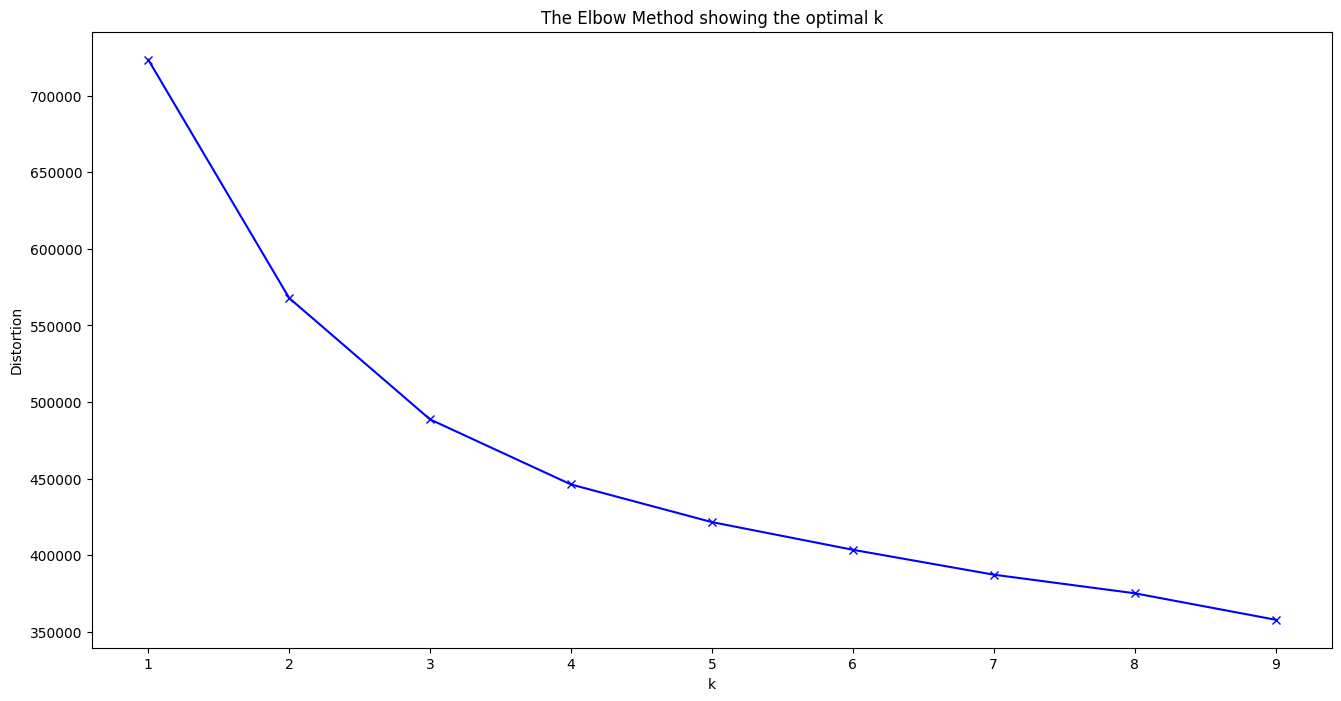

In [30]:
#Using the elbow method on Cosine distance
elbow_method(df_cosine, 10)

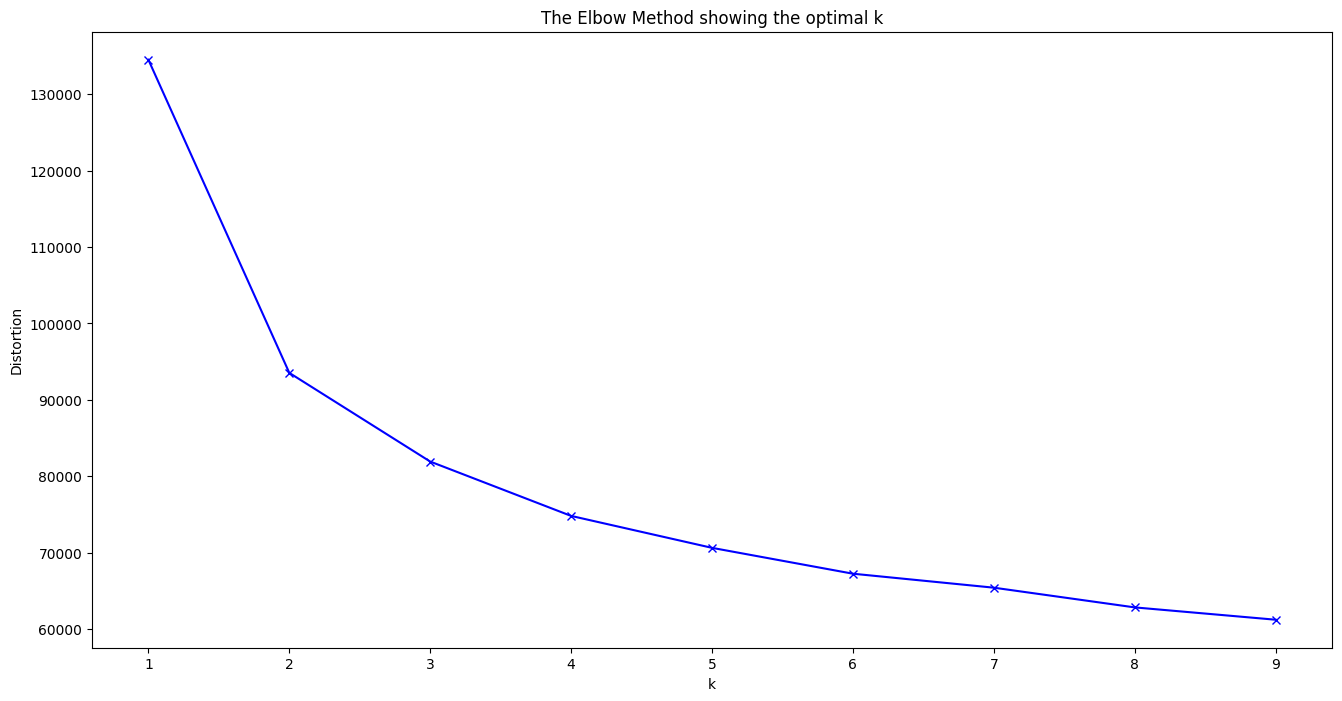

In [31]:
#Using the elbow method on Euclidean distance
elbow_method(Dist_euclidean, 10)

First, we have to modify our df in order to keep the first n users and assign our labels to them

In [32]:
ratings_matrix = ratings_matrix.head(100)
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,29625,29626,29627,29628,29629,29630,29631,29632,29633,29634
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we'll use the PCA method in order to reduce the dimensionality of our matrix and plot our clusters

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# instantiate StandardScaler and PCA with 2 components for 2D scatter plot
scaler = StandardScaler()
pca = PCA(n_components=2)

# fit and transform the ratings matrix
ratings_pca = pca.fit_transform(ratings_matrix)

# print the explained variance ratio for each component
print(pca.explained_variance_ratio_)

[0.03489446 0.02511166]


In [34]:
# create a new dataframe with the PCA components and user index
df_pca = pd.DataFrame(ratings_pca, index=range(0, 100))
df_pca['Cluster'] = labels_euclidean
df_pca

,0,1,Cluster
0,10.060076,-2.395855,1
1,-7.407720,-8.915989,2
2,-1.634958,-4.163751,1
3,36.178807,5.198943,0
4,-28.941764,48.374185,3
...,...,...,...
95,24.712579,0.261105,1
96,2.644529,-5.134898,1
97,20.487685,0.102011,0
98,7.944083,-4.964076,1


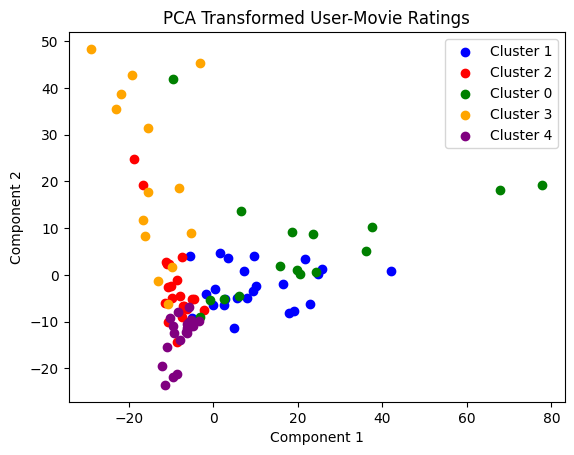

In [35]:
# create a scatter plot of the PCA components
fig, ax = plt.subplots()

for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
    group = df_pca.groupby('Cluster').get_group(label)
    ax.scatter(group[0], group[1], c=color, label=f'Cluster {label}')

# set the axis labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('PCA Transformed User-Movie Ratings')

# add a legend
ax.legend()

# show the plot
plt.show()